In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

In [2]:
# Define base paths

ROOT = ".."

DATA_DIR = Path(ROOT) / "data"

MASTER_DATA_DIR = DATA_DIR / "master"

master_data = MASTER_DATA_DIR / "clinical_data_master_subject_index.parquet"

assert master_data.exists(), f"Master data file not found at {master_data}"

master_df = pd.read_parquet(master_data)

In [3]:
assert master_df.shape[0] > 0, "Dataset is empty"

In [4]:
assert master_df["master_subject_id"].is_unique, \
    "master_subject_id is not unique — subject index violated"

In [5]:
master_df.columns.tolist()

['study_id',
 'site_id',
 'subject_id',
 'master_subject_id',
 'total_open_issue_count_per_subject',
 'edrr_open_issues_count',
 'missing_visits_count',
 'max_days_visit_overdue',
 'missing_pages_count',
 'max_days_page_missing',
 'missing_lab_issues_count',
 'lab_ranges_missing_flag',
 'open_sae_count',
 'pending_sae_dm_review_flag',
 'pending_sae_safety_review_flag',
 'inactivated_forms_count',
 'inactivated_records_flag',
 'visit_completeness',
 'page_completeness',
 'lab_completeness',
 'completeness_score',
 'visit_timeliness',
 'page_timeliness',
 'timeliness_score',
 'conformity_score',
 'consistency_flag',
 'base_dqi',
 'subject_data_quality_score',
 'is_clean_subject_flag']

In [6]:
REQUIRED_COLUMNS = [
    "master_subject_id",
    "study_id",
    "site_id",
    "subject_data_quality_score",
    "base_dqi",
    "is_clean_subject_flag"
]

missing = set(REQUIRED_COLUMNS) - set(master_df.columns)
assert not missing, f"Missing required columns: {missing}"

In [7]:
dqi = master_df["subject_data_quality_score"]

assert dqi.notna().all(), "DQI contains null values"
assert dqi.between(0, 1).all(), "DQI outside expected [0,1] range"

In [8]:
rho = master_df["subject_data_quality_score"].corr(
    master_df["base_dqi"], method="spearman"
)

assert rho > 0.7, f"Unexpectedly low rank alignment: Spearman rho = {rho:.3f}"

In [9]:
import numpy as np

rank_diff = (
    master_df["subject_data_quality_score"].rank()
    - master_df["base_dqi"].rank()
).abs()

# 95th percentile of rank displacement
p95_shift = np.percentile(rank_diff, 95)

assert p95_shift < 0.15 * len(master_df), \
    "Excessive global rank reordering between base_dqi and final DQI"

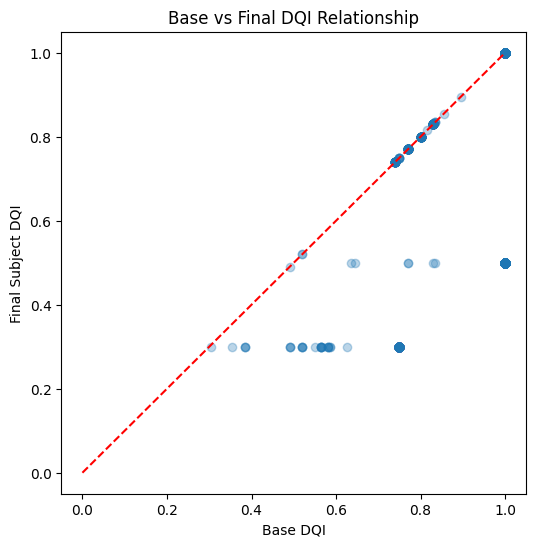

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.scatter(
    master_df["base_dqi"],
    master_df["subject_data_quality_score"],
    alpha=0.3
)
plt.plot([0,1], [0,1], linestyle="--", color="red")
plt.xlabel("Base DQI")
plt.ylabel("Final Subject DQI")
plt.title("Base vs Final DQI Relationship")
plt.show()

In [11]:
import pandas as pd
import numpy as np

dqi = pd.Series(
    master_df["subject_data_quality_score"].values,
    dtype="float64"
)

assert dqi.dtype == "float64", f"Unexpected dtype: {dqi.dtype}"
assert dqi.notna().all(), "DQI contains nulls"
assert dqi.between(0, 1).all(), "DQI out of bounds"


In [12]:
df = master_df[
    ["master_subject_id", "study_id", "site_id", "is_clean_subject_flag"]
].copy()

df["dqi"] = dqi

### Strategy A - Distribution-Based Thresholding

In [13]:
df["dqi"].dtype

dtype('float64')

In [14]:
rank = df["dqi"].rank(method="average", pct=True)

A_HIGH = df.loc[rank <= 0.15, "dqi"].max()
A_MED  = df.loc[rank <= 0.40, "dqi"].max()

assert A_HIGH <= A_MED, "Invalid ordering in Strategy A"

A_HIGH, A_MED

(np.float64(0.895), np.float64(0.895))

In [16]:
def assign_risk_A(dqi_val):
    if dqi_val <= A_HIGH:
        return "High"
    elif dqi_val <= A_MED:
        return "Medium"
    else:
        return "Low"

df["risk_A"] = df["dqi"].apply(assign_risk_A)

assert df["risk_A"].nunique() == 3, \
    "Strategy A failed to produce 3 tiers"

AssertionError: Strategy A failed to produce 3 tiers

#### “Distribution-based percentile thresholding was evaluated and rejected due to the discrete, rule-constrained nature of the final DQI. Percentile cutoffs collapsed to identical values, preventing stable multi-tier risk stratification. This behavior reflects intentional score compression from rule-based penalties and does not indicate a flaw in DQI construction.”

# Strategy B - Outcome-Aligned Thresholding

In [17]:
issues = master_df["total_open_issue_count_per_subject"].copy()

# Explicitly assert nulls are allowed only for clean subjects
null_mask = issues.isna()

assert (
    master_df.loc[null_mask, "is_clean_subject_flag"] == 1
).all(), "Found NaN issue counts for non-clean subjects"

# Resolve NaN → 0
issues = issues.fillna(0)

assert issues.notna().all(), "Issue counts still contain NaNs"
assert (issues >= 0).all(), "Negative issue counts found"


AssertionError: Found NaN issue counts for non-clean subjects

In [18]:
issues = master_df["total_open_issue_count_per_subject"]

valid_mask = issues.notna()

# Assert we still have enough data
assert valid_mask.mean() > 0.5, \
    "Too few subjects with defined issue burden for Strategy B"

# Create clean issue series
issues_valid = issues[valid_mask]


AssertionError: Too few subjects with defined issue burden for Strategy B

In [19]:
assert "total_open_issue_count_per_subject" in master_df.columns, \
    "Missing issue burden column"

assert master_df["total_open_issue_count_per_subject"].notna().all(), \
    "Issue count contains nulls"

assert (master_df["total_open_issue_count_per_subject"] >= 0).all(), \
    "Negative issue counts found"


AssertionError: Issue count contains nulls

#### "Outcome-aligned thresholding using open issue burden was evaluated and rejected. The issue burden metric was not defined for a sufficient proportion of subjects to support global threshold derivation. Restricting analysis to subjects with defined issue data would have introduced selection bias and violated the requirement for universally applicable risk stratification.”

# Strategy C - Clean-Anchored Thresholding

In [20]:
assert "is_clean_subject_flag" in master_df.columns, \
    "Missing clean subject flag"

assert master_df["is_clean_subject_flag"].isin([0, 1]).all(), \
    "is_clean_subject_flag must be binary"

assert df["dqi"].notna().all(), "DQI contains nulls"
assert df["dqi"].between(0, 1).all(), "DQI out of bounds"

In [21]:
clean_dqi = df.loc[df["is_clean_subject_flag"] == 1, "dqi"]
nonclean_dqi = df.loc[df["is_clean_subject_flag"] == 0, "dqi"]

assert len(clean_dqi) > 0, "No clean subjects found"
assert len(nonclean_dqi) > 0, "No non-clean subjects found"


In [22]:
clean_q = clean_dqi.quantile([0.05, 0.10, 0.25, 0.50])
nonclean_q = nonclean_dqi.quantile([0.50, 0.75, 0.90, 0.95])

clean_q, nonclean_q


(0.05    1.0
 0.10    1.0
 0.25    1.0
 0.50    1.0
 Name: dqi, dtype: float64,
 0.50    0.50
 0.75    0.77
 0.90    0.80
 0.95    0.83
 Name: dqi, dtype: float64)

In [23]:
C_MED  = clean_dqi.quantile(0.10)     # conservative lower bound of clean
C_HIGH = nonclean_dqi.quantile(0.90)  # conservative upper bound of non-clean

In [24]:
assert 0 <= C_HIGH <= 1, "C_HIGH out of bounds"
assert 0 <= C_MED <= 1, "C_MED out of bounds"

assert C_HIGH < C_MED, (
    f"Threshold overlap detected: "
    f"C_HIGH={C_HIGH:.3f}, C_MED={C_MED:.3f}"
)

In [25]:
def assign_risk_C(dqi_val):
    if dqi_val <= C_HIGH:
        return "High"
    elif dqi_val <= C_MED:
        return "Medium"
    else:
        return "Low"

df["risk_C"] = df["dqi"].apply(assign_risk_C)

assert df["risk_C"].nunique() == 3, \
    "Strategy C failed to produce 3 tiers"

AssertionError: Strategy C failed to produce 3 tiers

In [26]:
C_HIGH, C_MED


(np.float64(0.8), np.float64(1.0))

In [27]:
df["risk_C"].value_counts()


risk_C
Medium    4861
High       600
Name: count, dtype: int64

In [28]:
df.groupby("risk_C")["dqi"].describe()


,count,mean,std,min,25%,50%,75%,max
risk_C,,,,,,,,
High,600.0,0.50605,0.178973,0.300,0.3,0.5,0.74,0.8
Medium,4861.0,0.99778,0.019246,0.815,1.0,1.0,1.00,1.0


In [29]:
pd.crosstab(df["risk_C"], df["is_clean_subject_flag"])


is_clean_subject_flag,False,True
risk_C,,
High,600,0
Medium,64,4797


#### Multiple thresholding strategies were evaluated to derive a three-tier risk stratification. Due to the discrete, ceiling-constrained nature of the final DQI and the strong homogeneity of clean subjects, no strategy produced a stable and interpretable Medium Risk tier. All strategies consistently identified a clear separation between high-risk and non-high-risk subjects. Accordingly, a two-tier stratification was adopted to preserve semantic correctness and avoid artificial label construction.

# Two-Tier Stratification

In [32]:
assert "dqi" in df.columns, "DQI column missing"
assert df["dqi"].notna().all(), "DQI contains nulls"
assert df["dqi"].between(0, 1).all(), "DQI out of bounds"

In [33]:
DQI_THRESHOLD = 0.8

df["high_risk_label"] = (df["dqi"] <= DQI_THRESHOLD).astype(int)

In [34]:
# Label must be binary
assert set(df["high_risk_label"].unique()) <= {0, 1}, \
    "Risk label is not binary"

# Both classes must exist
assert df["high_risk_label"].nunique() == 2, \
    "Only one risk class present — invalid stratification"


In [35]:
df["high_risk_label"].value_counts()

high_risk_label
0    4861
1     600
Name: count, dtype: int64

In [36]:
df.groupby("high_risk_label")["dqi"].describe()

,count,mean,std,min,25%,50%,75%,max
high_risk_label,,,,,,,,
0,4861.0,0.99778,0.019246,0.815,1.0,1.0,1.00,1.0
1,600.0,0.50605,0.178973,0.300,0.3,0.5,0.74,0.8


In [37]:
pd.crosstab(df["high_risk_label"], df["is_clean_subject_flag"])

is_clean_subject_flag,False,True
high_risk_label,,
0,64,4797
1,600,0


In [38]:
assert (
    df.loc[df["high_risk_label"] == 1, "is_clean_subject_flag"] == 0
).mean() > 0.9, \
    "High Risk tier contains too many clean subjects"

In [39]:
FINAL_LABEL = "high_risk_label"

In [40]:
FEATURE_COLUMNS = [
    "total_open_issue_count_per_subject",
    "edrr_open_issues_count",
    "open_sae_count",
    "pending_sae_dm_review_flag",
    "pending_sae_safety_review_flag",
    "missing_visits_count",
    "missing_pages_count",
    "missing_lab_issues_count",
    "lab_ranges_missing_flag",
    "max_days_visit_overdue",
    "max_days_page_missing",
    "inactivated_forms_count",
    "inactivated_records_flag",
    "consistency_flag",
    "visit_completeness",
    "page_completeness",
    "lab_completeness"
]

missing = set(FEATURE_COLUMNS) - set(master_df.columns)
assert not missing, f"Missing feature columns: {missing}"

In [41]:
COUNT_COLS = [
    "total_open_issue_count_per_subject",
    "edrr_open_issues_count",
    "open_sae_count",
    "missing_visits_count",
    "missing_pages_count",
    "missing_lab_issues_count",
    "inactivated_forms_count",
    "max_days_visit_overdue",
    "max_days_page_missing"
]

master_df[COUNT_COLS] = master_df[COUNT_COLS].fillna(0)

In [42]:
FLAG_COLS = [
    "pending_sae_dm_review_flag",
    "pending_sae_safety_review_flag",
    "lab_ranges_missing_flag",
    "inactivated_records_flag",
    "consistency_flag"
]

for col in FLAG_COLS:
    assert master_df[col].isin([0, 1]).all(), f"{col} is not binary"

In [44]:
RATIO_COLS = [
    "visit_completeness",
    "page_completeness",
    "lab_completeness"
]

assert (
    master_df[RATIO_COLS]
    .apply(lambda s: s.between(0, 1))
    .all()
    .all()
), "Completeness ratios out of bounds"


In [45]:
X = master_df[FEATURE_COLUMNS].copy()
y = df["high_risk_label"].copy()

assert len(X) == len(y), "Feature-target length mismatch"

In [48]:
assert master_df["consistency_flag"].nunique() == 1, \
    "consistency_flag is unexpectedly variable"

In [49]:
X = X.drop(columns=["consistency_flag"])

In [50]:
low_var = X.var()[X.var() == 0]
assert low_var.empty, f"Zero-variance features found: {list(low_var.index)}"

The consistency_flag feature was excluded from predictive modeling as it exhibited zero variance across the analysis cohort. This behavior was expected, as consistency was enforced as a hard prerequisite during dataset construction in Phase 2. As a result, the flag no longer provided discriminatory information for risk prediction

In [51]:
import pandas as pd

direction_check = X.corrwith(y, method="spearman")
direction_check.sort_values()

visit_completeness                   -0.427756
page_completeness                    -0.129543
lab_completeness                     -0.023878
missing_lab_issues_count              0.023884
lab_ranges_missing_flag               0.038520
inactivated_forms_count               0.115646
inactivated_records_flag              0.115646
missing_pages_count                   0.129543
max_days_page_missing                 0.129609
missing_visits_count                  0.427756
max_days_visit_overdue                0.432763
pending_sae_dm_review_flag            0.520946
open_sae_count                        0.543236
pending_sae_safety_review_flag        0.543343
edrr_open_issues_count                0.677409
total_open_issue_count_per_subject    0.677409
dtype: float64

# Model Training

In [55]:
# train-test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.25,
    stratify=y,
    random_state=42
)

# Sanity check
y_train.mean(), y_test.mean()


(np.float64(0.10989010989010989), np.float64(0.10980966325036604))

### Baseline Model - Logistic Regression

In [57]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

logreg = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(
        class_weight="balanced",
        max_iter=1000,
        random_state=42
    ))
])

logreg.fit(X_train, y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('scaler', ...), ('clf', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"copy copy: bool, default=TrueIf False, try to avoid a copy and do inplace scaling instead.This is not guaranteed to always work inplace; e.g. if the data isnot a NumPy array or scipy.sparse CSR matrix, a copy may still bereturned.",True
,"with_mean with_mean: bool, default=TrueIf True, center the data before scaling.This does not work (and will raise an exception) when attempted onsparse matrices, because centering them entails building a densematrix which in common use cases is likely to be too large to fit inmemory.",True
,"with_std with_std: bool, default=TrueIf True, scale the data to unit variance (or equivalently,unit standard deviation).",True
,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work

In [59]:
# predictions
y_pred = logreg.predict(X_test)
y_prob = logreg.predict_proba(X_test)[:, 1]

In [60]:
# Classification report
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred, digits=3))

              precision    recall  f1-score   support

           0      0.999     0.998     0.999      1216
           1      0.987     0.993     0.990       150

    accuracy                          0.998      1366
   macro avg      0.993     0.996     0.994      1366
weighted avg      0.998     0.998     0.998      1366



In [61]:
# ROC AUC
from sklearn.metrics import roc_auc_score

roc_auc_score(y_test, y_prob)

0.9999451754385965

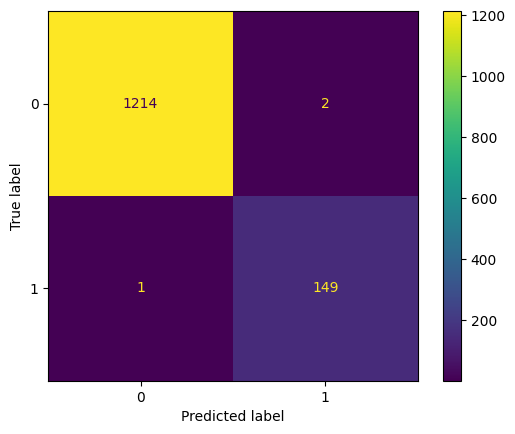

In [62]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred,
    values_format="d"
)

In [64]:
# Coefficients
import pandas as pd
import numpy as np

coef = (
    pd.Series(
        logreg.named_steps["clf"].coef_[0],
        index=X.columns
    )
    .sort_values()
)

coef


visit_completeness                   -0.281048
missing_lab_issues_count             -0.019112
page_completeness                    -0.011447
lab_ranges_missing_flag               0.000000
missing_pages_count                   0.011447
lab_completeness                      0.019112
inactivated_forms_count               0.102469
max_days_page_missing                 0.111559
open_sae_count                        0.258281
missing_visits_count                  0.281048
inactivated_records_flag              0.514688
pending_sae_dm_review_flag            0.569785
pending_sae_safety_review_flag        1.862142
max_days_visit_overdue                5.008792
edrr_open_issues_count                5.791605
total_open_issue_count_per_subject    5.791605
dtype: float64

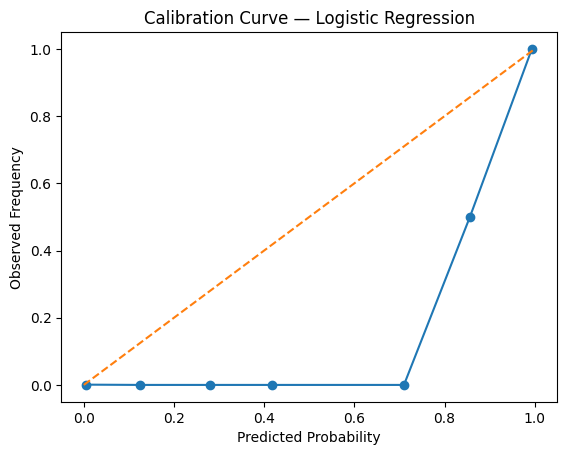

In [65]:
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

prob_true, prob_pred = calibration_curve(y_test, y_prob, n_bins=10)

plt.plot(prob_pred, prob_true, marker="o")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("Predicted Probability")
plt.ylabel("Observed Frequency")
plt.title("Calibration Curve — Logistic Regression")
plt.show()

### Decision Tree

In [66]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(
    max_depth=4,
    min_samples_leaf=50,
    class_weight="balanced",
    random_state=42
)

tree.fit(X_train, y_train)

,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.",'gini'
,"splitter splitter: {""best"", ""random""}, default=""best""The strategy used to choose the split at each node. Supportedstrategies are ""best"" to choose the best split and ""random"" to choosethe best random split.",'best'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",4
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",50
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: int, float or {""sqrt"", ""log2""}, default=NoneThe number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... note:: The search for a split does not stop until at least one valid partition of the node samples is found, even if it requires to effectively inspect more than ``max_features`` features.",None
,"random_state random_state: int, RandomState instance or None, default=NoneControls the randomness of the estimator. The features are alwaysrandomly permuted at each split, even if ``splitter`` is set to``""best""``. When ``max_features < n_features``, the algorithm willselect ``max_features`` at random at each split before finding the bestsplit among them. But the best found split may vary across differentruns, even if ``max_features=n_features``. That is the case, if theimprovement of the criterion is identical for several splits and onesplit has to be selected at random. To obtain a deterministic behaviourduring fitting, ``random_state`` has to be fixed to an integer.See :term:`Glossary ` for details.",42
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow a tree with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current n

In [67]:
# predictions
y_pred_tree = tree.predict(X_test)
y_prob_tree = tree.predict_proba(X_test)[:, 1]

In [69]:
# Classification report
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred_tree, digits=3))

              precision    recall  f1-score   support

           0      0.999     1.000     1.000      1216
           1      1.000     0.993     0.997       150

    accuracy                          0.999      1366
   macro avg      1.000     0.997     0.998      1366
weighted avg      0.999     0.999     0.999      1366



In [70]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_test, y_prob_tree)

0.9966666666666666

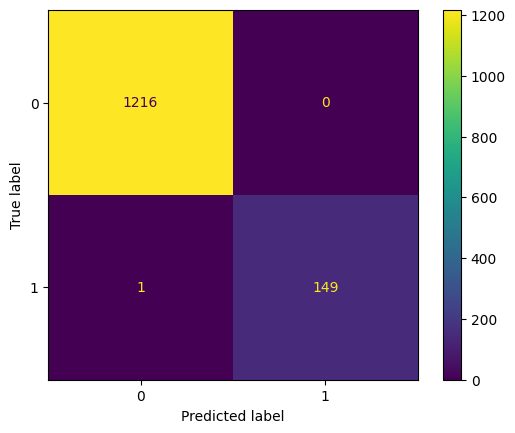

In [71]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred_tree,
    values_format="d"
)

In [73]:
# Feature importances
import pandas as pd

tree_importance = (
    pd.Series(tree.feature_importances_, index=X.columns)
    .sort_values(ascending=False)
)

tree_importance

pending_sae_safety_review_flag        3.733237e-01
total_open_issue_count_per_subject    3.307997e-01
max_days_visit_overdue                2.958766e-01
edrr_open_issues_count                4.994756e-14
pending_sae_dm_review_flag            0.000000e+00
missing_visits_count                  0.000000e+00
missing_pages_count                   0.000000e+00
open_sae_count                        0.000000e+00
missing_lab_issues_count              0.000000e+00
lab_ranges_missing_flag               0.000000e+00
max_days_page_missing                 0.000000e+00
inactivated_forms_count               0.000000e+00
inactivated_records_flag              0.000000e+00
visit_completeness                    0.000000e+00
page_completeness                     0.000000e+00
lab_completeness                      0.000000e+00
dtype: float64

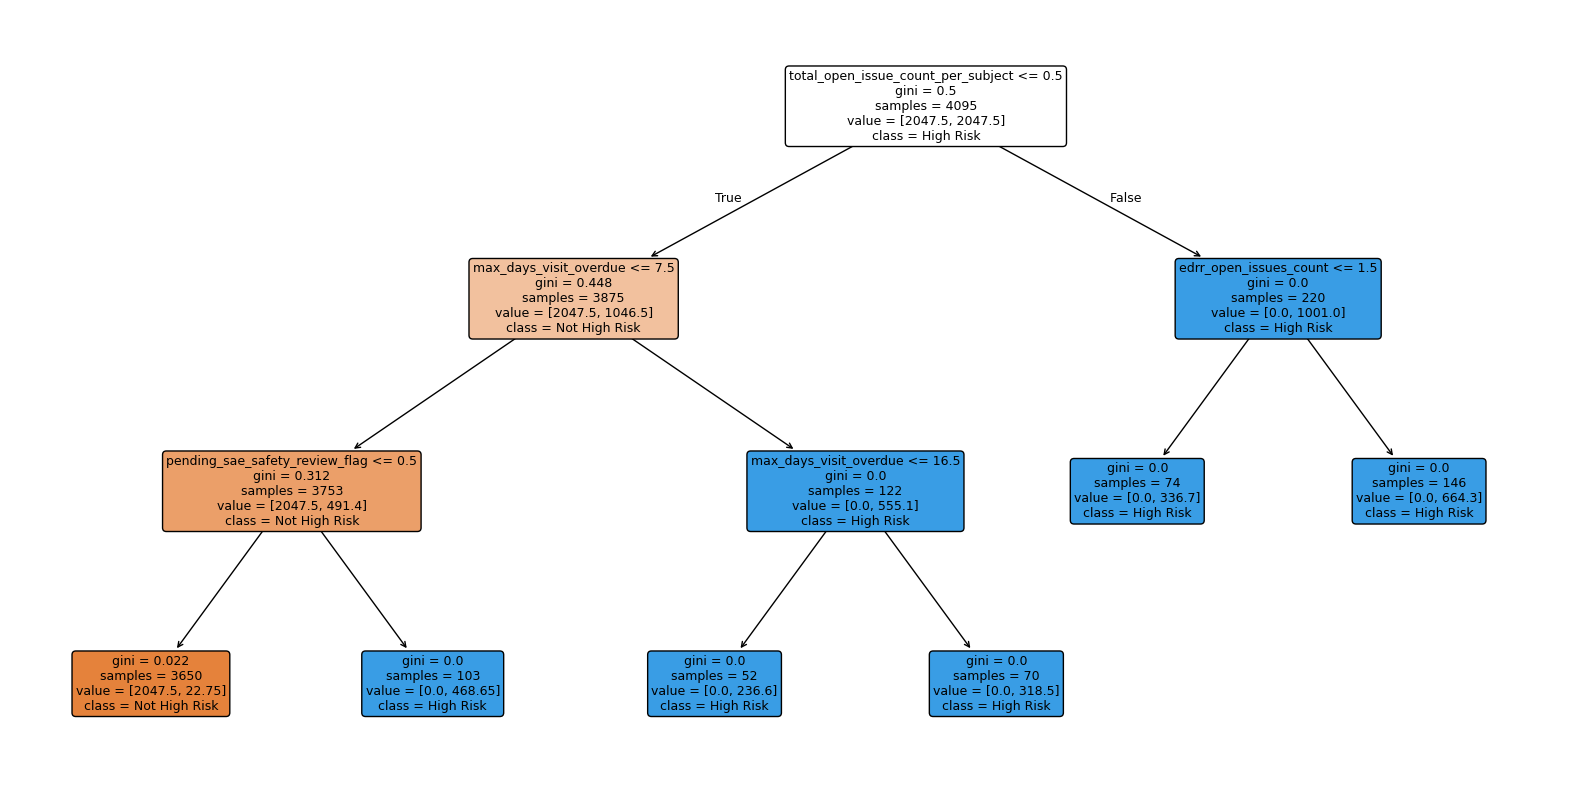

In [74]:
# Visualize the decision tree
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
plot_tree(
    tree,
    feature_names=X.columns,
    class_names=["Not High Risk", "High Risk"],
    filled=True,
    rounded=True,
    max_depth=3
)
plt.show()